# CS445 Final Project: Face Swapping

### Group Members:

Hongxiao Chen, Shuai Wei, Zhexuan Yin

### Motivation
The objective for this project is to be able to capture a facial expression from one image and put it on another person. The motivation for this project is that people may want to capture an expression from another person, and then be able to apply it to another image. By completing this project, we hope to learn how to capture facial expression and blend naturally onto another image. 

## Setup

In [98]:
import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt

## Transforming Triangles

The face is divided into triangles and then each triangle is swapped to maintain the proportions and align with the expressions of the new face.

In [99]:
def get_transform(source_pt, target_pt):
    x = np.ones((3,3))
    y = np.ones((3,3))
    
    x[0:2, :] = source_pt.T
    y[0:2, :] = target_pt.T
    
    xt = np.linalg.inv(x)
    T = np.matmul(y, xt)
    T[2, :] = [0,0,1]
    return T

def apply_transform(pts, T):
    n = pts.shape[1]
    warp_pt = np.ones((2,n))
    for i in range(n):
        pt = np.ones((3,1))
        pt[0] = pts[0][i]
        pt[1] = pts[1][i]
        pt = np.matmul(T, pt)
        warp_pt[:, i] = pt[:2, 0]
        
    return warp_pt

## Landmark & Triangulation source image

In [100]:
def get_landmarks(image, detector, predictor):
  faces = detector(image, 1)
  shape = predictor(image, faces[0])
  landmarks = [(p.x, p.y) for p in shape.parts()]

  return landmarks

In [101]:
def show_landmarks(image, landmarks, index=None):
  points_img = np.copy(image)
  for i, point in enumerate(landmarks):
    if index != None and i == index:
      cv2.circle(points_img, tuple(point), 5, (255, 0, 0), -1)
    else:
      cv2.circle(points_img, tuple(point), 5, (0, 0, 255), -1)
  plt.figure()
  plt.imshow(points_img[:,:,[2,1,0]])

In [102]:
def get_delaunay_triangles(landmarks, img_shape):
  mask = np.zeros(img_shape, dtype=np.uint8)
  subdiv = cv2.Subdiv2D((0, 0, mask.shape[1], mask.shape[0]))

  for p in landmarks:
    subdiv.insert(p)

  triangles = subdiv.getTriangleList()

  # Convert the triangle indices to the actual landmark points
  delaunay_triangles = []
  for t in triangles:
    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])

    if all(0 <= x < mask.shape[1] and 0 <= y < mask.shape[0] for (x, y) in (pt1, pt2, pt3)):
      index_pt1 = landmarks.index(pt1)
      index_pt2 = landmarks.index(pt2)
      index_pt3 = landmarks.index(pt3)

      delaunay_triangles.append((index_pt1, index_pt2, index_pt3))

  return delaunay_triangles

In [103]:
def triangle_index_to_triangles(triangle_index, landmarks):
  pt1 = landmarks[triangle_index[0]]
  pt2 = landmarks[triangle_index[1]]
  pt3 = landmarks[triangle_index[2]]
  return np.array([pt1, pt2, pt3], np.int32)

In [104]:
def show_triangles(image, landmarks, triangle_indices):
  triangles_img = np.copy(image)

  triangles = [triangle_index_to_triangles(index, landmarks) for index in triangle_indices]
  cv2.polylines(triangles_img, np.array(triangles), True, (255, 255, 255), thickness=2)

  plt.figure()
  plt.imshow(triangles_img[:,:,[2,1,0]])

## Part 3: Link the warped triangles together & Replace the face on the destination image

In [105]:
def calculate_new_face(img, img2, shape1, shape2, delaunay_triangles1, landmarks1, landmarks2, get_transform=cv2.getAffineTransform, apply_transform=cv2.warpAffine):
  img2_new_face = np.zeros(img2.shape, np.uint8)
  (H1, W1) = shape1
  (H2, W2) = shape2
  for triangle_indices in delaunay_triangles1:
    triangle1 = triangle_index_to_triangles(triangle_indices, landmarks1)
    cropped_tr1_mask = np.zeros((H1, W1), np.uint8)
    
    cv2.fillConvexPoly(cropped_tr1_mask, triangle1, 255)

    triangle2 = triangle_index_to_triangles(triangle_indices, landmarks2)
    cropped_tr2_mask = np.zeros((H2, W2), np.uint8)

    cv2.fillConvexPoly(cropped_tr2_mask, triangle2, 255)

    # Warp triangles
    triangle1 = np.float32(triangle1)
    triangle2 = np.float32(triangle2)
  
    M = get_transform(triangle1, triangle2)
    warped_img_part = apply_transform(img, M, (W2, H2))
    warped_img_part = cv2.bitwise_and(warped_img_part, warped_img_part, mask=cropped_tr2_mask)

    # Remove the overlap part of newly added region
    overlap_mask = cv2.bitwise_and(img2_new_face, warped_img_part)
    warped_img_part = cv2.bitwise_xor(warped_img_part, overlap_mask)
    # Building the destination face
    img2_new_face = cv2.add(img2_new_face, warped_img_part)
  return img2_new_face

In [106]:
def transform_by_landmarks(img1, img2, landmarks1, landmarks2):
  # Calculate triangles
  convexhull2 = cv2.convexHull(np.array(landmarks2))
  delaunay_triangles1 = get_delaunay_triangles(landmarks1, img1.shape)

  # Calculate the new face that will be applied to img2
  img2_new_face = calculate_new_face(img1, img2, img1.shape[:2], img2.shape[:2], delaunay_triangles1, landmarks1, landmarks2)

  # Remove the face from img2 then paste the new face
  img2_face_mask = cv2.fillConvexPoly(np.zeros(img2.shape[:2], dtype=np.uint8), convexhull2, 255)
  img2_head_noface = cv2.bitwise_and(img2, img2, mask=cv2.bitwise_not(img2_face_mask))
  result = cv2.add(img2_head_noface, img2_new_face)

  # Use seamless clone from cv2
  (x, y, w, h) = cv2.boundingRect(convexhull2)
  center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

  seamlessclone = cv2.seamlessClone(result, img2, img2_face_mask, center_face2, cv2.NORMAL_CLONE)

  return seamlessclone

In [107]:
def auto_swap_face(img1, img2, is_display = False):
  # Initialization
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor("utils/shape_predictor_68_face_landmarks.dat")

  # Calculate landmarks
  landmarks1 = get_landmarks(img1, detector, predictor)
  landmarks2 = get_landmarks(img2, detector, predictor)

  if (is_display):
    show_landmarks(img1, landmarks1, index=None)
    show_landmarks(img2, landmarks2, index=None)

    delaunay_triangles1 = get_delaunay_triangles(landmarks1, img1.shape)
    show_triangles(img1, landmarks1, delaunay_triangles1)

    delaunay_triangles2 = get_delaunay_triangles(landmarks2, img2.shape)
    show_triangles(img2, landmarks2, delaunay_triangles2)

  return transform_by_landmarks(img1, img2, landmarks1, landmarks2)

## Result Display

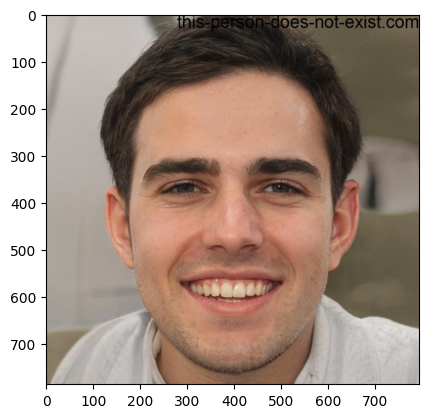

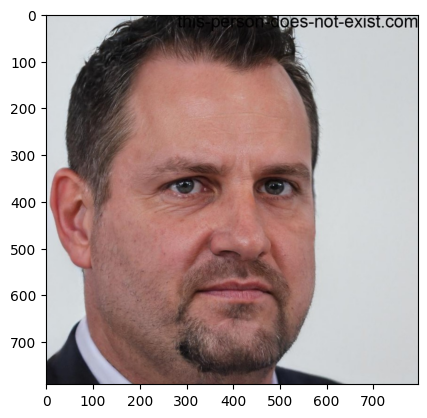

In [108]:
# Import
img1 = cv2.imread("images/test1.jpg")
plt.imshow(img1[:, :, [2, 1, 0]])

plt.figure()
img2 = cv2.imread("images/test3.jpg")
plt.imshow(img2[:, :, [2, 1, 0]])

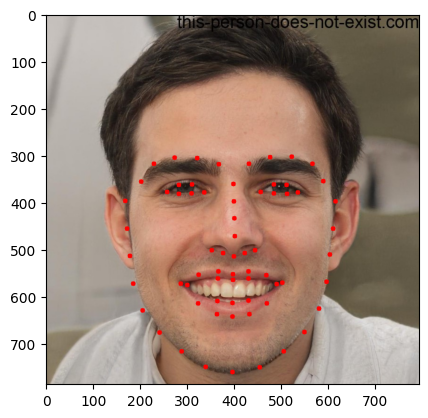

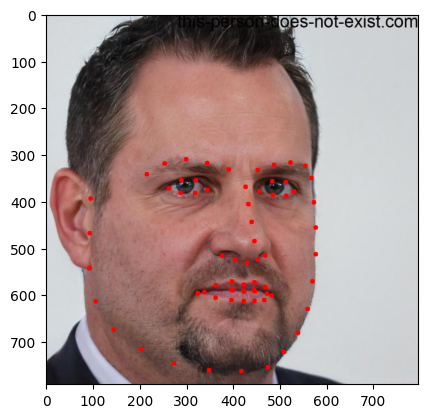

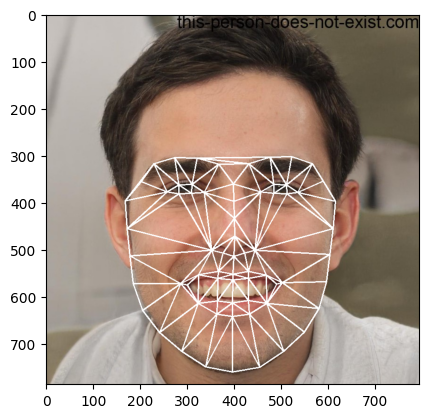

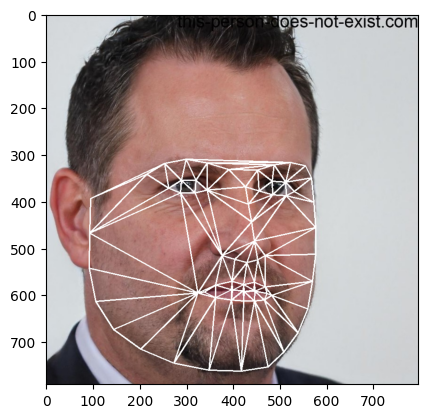

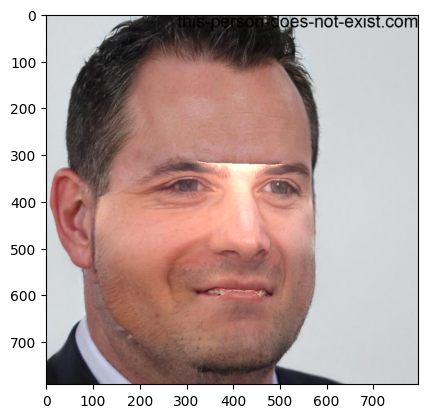

In [109]:
result = auto_swap_face(img1, img2, is_display = True)

plt.figure()
plt.imshow(result[:,:,[2,1,0]])